In [2]:
import torch

if torch.backends.mps.is_available():
    print("✅ MPS (Metal) backend is available and enabled.")
else:
    print("❌ MPS not available.")

✅ MPS (Metal) backend is available and enabled.


In [3]:
# Data simulation, See chapter 1
import numpy as np
import pandas as pd

class ZooplusSimulator:
    """
    A simulated environment for the Zooplus recommendation problem.

    This class manages:
    1. A product catalog with features (category).
    2. A set of user personas with distinct preferences.
    3. A stochastic reward function to simulate user clicks (CTR).
    """
    def __init__(self, n_products=50, n_users=1000, seed=42):
        """
        Initializes the simulation environment.
        
        Args:
            n_products (int): The total number of products in the catalog.
            n_users (int): The total number of unique users in the simulation.
            seed (int): Random seed for reproducibility.
        """
        self.rng = np.random.default_rng(seed)
        self.n_products = n_products
        self.n_users = n_users
        
        # 1. Create the Product Catalog
        self.products = self._create_product_catalog()
        
        # 2. Create User Personas and assign each of the n_users to a persona
        self.personas = self._create_user_personas()
        self.user_to_persona_map = self._assign_users_to_personas()

    def _create_product_catalog(self):
        """Creates a pandas DataFrame of products."""
        product_ids = range(self.n_products)
        # Ensure a balanced representation of categories
        categories = ['Fish Supplies', 'Cat Food', 'Dog Food', 'Dog Toy', 'Cat Toy']
        num_per_category = self.n_products // len(categories)
        cat_list = []
        for cat in categories:
            cat_list.extend([cat] * num_per_category)
        # Fill the remainder, if any
        cat_list.extend(self.rng.choice(categories, self.n_products - len(cat_list)))
        
        product_data = {
            'product_id': product_ids,
            'category': self.rng.permutation(cat_list) # Shuffle categories
        }
        return pd.DataFrame(product_data).set_index('product_id')

    def _create_user_personas(self):
        """Defines a dictionary of user personas and their preferences (base CTRs)."""
        return {
            'new_puppy_parent': {'Dog Food': 0.40, 'Dog Toy': 0.50, 'Cat Food': 0.10, 'Cat Toy': 0.05, 'Fish Supplies': 0.02},
            'cat_connoisseur':  {'Dog Food': 0.05, 'Dog Toy': 0.02, 'Cat Food': 0.55, 'Cat Toy': 0.45, 'Fish Supplies': 0.05},
            'budget_shopper':   {'Dog Food': 0.25, 'Dog Toy': 0.15, 'Cat Food': 0.40, 'Cat Toy': 0.20, 'Fish Supplies': 0.20},
            'fish_hobbyist':    {'Dog Food': 0.02, 'Dog Toy': 0.02, 'Cat Food': 0.10, 'Cat Toy': 0.08, 'Fish Supplies': 0.60}
        }
        
    def _assign_users_to_personas(self):
        """Randomly assigns each user ID to one of the defined personas."""
        persona_names = list(self.personas.keys())
        return {user_id: self.rng.choice(persona_names) for user_id in range(self.n_users)}

    def get_true_ctr(self, user_id, product_id):
        """Returns the ground-truth, noise-free click probability."""
        if user_id not in self.user_to_persona_map or product_id not in self.products.index:
            return 0.0
            
        persona_name = self.user_to_persona_map[user_id]
        persona_prefs = self.personas[persona_name]
        
        product_category = self.products.loc[product_id, 'category']
        
        # The true CTR is directly from the persona's preferences for that category
        click_prob = persona_prefs.get(product_category, 0.01) # Default for unknown categories
        return click_prob

    def get_reward(self, user_id, product_id):
        """
        Simulates a user-item interaction and returns a stochastic reward (1 for click, 0 for no-click).
        """
        click_prob = self.get_true_ctr(user_id, product_id)
        
        # Sample from a Bernoulli distribution to get a stochastic outcome
        # This simulates the inherent randomness of a user's click decision
        reward = self.rng.binomial(1, click_prob)
        return reward

    def get_random_user(self):
        """Returns a random user_id from the population."""
        return self.rng.integers(0, self.n_users)

In [4]:
# # --- Instantiate the simulator ---
# sim = ZooplusSimulator(seed=42)
# print("Simulation Initialized.")
# print("\nExample product data:")
# print(sim.products.head())
# print("\nExample user-persona mapping:")
# print({k: sim.user_to_persona_map[k] for k in range(5)})
# --- Instantiate the simulator ---
sim = ZooplusSimulator(seed=42)
print("Simulation Initialized.\n")

# --- A More Illustrative Test ---

# 1. Select a persona to test
test_persona = 'new_puppy_parent'

# 2. Find a user with this persona
test_user_id = -1
for user_id, persona in sim.user_to_persona_map.items():
    if persona == test_persona:
        test_user_id = user_id
        break

# 3. Find one relevant product and one irrelevant product
try:
    high_affinity_prod_id = sim.products[sim.products['category'] == 'Dog Toy'].index[0]
    low_affinity_prod_id = sim.products[sim.products['category'] == 'Cat Toy'].index[0]
except IndexError:
    print("Error: Could not find products of the required categories. Rerunning simulation setup.")
    # In a rare case of random assignment, a category might not exist.
    # We can handle this, but for this demo, we assume they exist.
    high_affinity_prod_id, low_affinity_prod_id = 3, 4 # Fallback for notebook consistency

# 4. Simulate many interactions to observe the average CTR
n_trials = 100
high_affinity_clicks = 0
low_affinity_clicks = 0

for _ in range(n_trials):
    high_affinity_clicks += sim.get_reward(test_user_id, high_affinity_prod_id)
    low_affinity_clicks += sim.get_reward(test_user_id, low_affinity_prod_id)

# 5. Report the results and compare to the ground truth
print(f"--- Testing Persona: '{test_persona}' (User ID: {test_user_id}) ---")
print(f"\n1. Interaction with High-Affinity Product (ID: {high_affinity_prod_id}, Category: 'Dog Toy')")
expected_high_ctr = sim.personas[test_persona]['Dog Toy']
observed_high_ctr = high_affinity_clicks / n_trials
print(f"  --> Expected CTR (from persona definition): {expected_high_ctr:.2%}")
print(f"  --> Observed CTR (from {n_trials} simulations): {observed_high_ctr:.2%}")

print(f"\n2. Interaction with Low-Affinity Product (ID: {low_affinity_prod_id}, Category: 'Cat Toy')")
expected_low_ctr = sim.personas[test_persona]['Cat Toy']
observed_low_ctr = low_affinity_clicks / n_trials
print(f"  --> Expected CTR (from persona definition): {expected_low_ctr:.2%}")
print(f"  --> Observed CTR (from {n_trials} simulations): {observed_low_ctr:.2%}")

Simulation Initialized.

--- Testing Persona: 'new_puppy_parent' (User ID: 0) ---

1. Interaction with High-Affinity Product (ID: 4, Category: 'Dog Toy')
  --> Expected CTR (from persona definition): 50.00%
  --> Observed CTR (from 100 simulations): 53.00%

2. Interaction with Low-Affinity Product (ID: 3, Category: 'Cat Toy')
  --> Expected CTR (from persona definition): 5.00%
  --> Observed CTR (from 100 simulations): 6.00%


In [5]:
# data generation : see chapter 1
def generate_training_data(simulator, num_interactions):
    """Generates a historical log of user-item interactions."""
    user_ids, product_ids, clicks = [], [], []
    
    print(f"Generating {num_interactions:,} interaction records...")
    for _ in range(num_interactions):
        user_id = simulator.get_random_user()
        product_id = simulator.rng.integers(0, simulator.n_products)
        
        click = simulator.get_reward(user_id, product_id)
        
        user_ids.append(user_id)
        product_ids.append(product_id)
        clicks.append(click)
        
    df = pd.DataFrame({
        'user_id': user_ids,
        'product_id': product_ids,
        'clicked': clicks
    })
    # Join with product category for later analysis
    df = df.join(simulator.products, on='product_id')
    return df

# Generate a dataset of 200,000 interactions
training_data = generate_training_data(sim, 200_000)
print("\nGenerated Training Data:")
print(training_data.head())
print(f"\nOverall Click-Through Rate (CTR) in dataset: {training_data.clicked.mean():.2%}")

Generating 200,000 interaction records...

Generated Training Data:
   user_id  product_id  clicked  category
0      209          22        0  Dog Food
1      207          24        0  Dog Food
2      394           7        0   Cat Toy
3        1          20        0   Dog Toy
4      862           5        0  Dog Food

Overall Click-Through Rate (CTR) in dataset: 21.01%


In [6]:
# deep recommendation model, see chapter 1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- Device Configuration ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon) device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

# --- 1. Define the Dataset Class ---
class RecommenderDataset(Dataset):
    def __init__(self, users, products, labels):
        self.users = torch.tensor(users, dtype=torch.long)
        self.products = torch.tensor(products, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.products[idx], self.labels[idx]

# --- 2. Define the Model Architecture ---
class MLPRecommender(nn.Module):
    def __init__(self, n_users, n_products, embedding_dim=32):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.product_embedding = nn.Embedding(n_products, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, product_ids):
        user_embeds = self.user_embedding(user_ids)
        product_embeds = self.product_embedding(product_ids)
        x = torch.cat([user_embeds, product_embeds], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return self.sigmoid(x)

# --- 3. Prepare Data and DataLoaders ---
train_df, val_df = train_test_split(training_data, test_size=0.2, random_state=42)
train_dataset = RecommenderDataset(train_df.user_id.values, train_df.product_id.values, train_df.clicked.values)
val_dataset = RecommenderDataset(val_df.user_id.values, val_df.product_id.values, val_df.clicked.values)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# --- 4. Instantiate Model, Loss, and Optimizer ---
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products).to(device)
criterion = nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = optim.Adam(batch_model.parameters(), lr=0.001)
print("\nPyTorch Model Architecture:")
print(batch_model)

# --- 5. The Training Loop ---
print("\nTraining the batched PyTorch model...")
n_epochs = 10
for epoch in range(n_epochs):
    batch_model.train()
    train_loss = 0
    for users, products, labels in train_loader:
        users, products, labels = users.to(device), products.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = batch_model(users, products).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    batch_model.eval()
    val_loss = 0
    with torch.no_grad():
        for users, products, labels in val_loader:
            users, products, labels = users.to(device), products.to(device), labels.to(device)
            outputs = batch_model(users, products).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")

print("\nTraining complete.")
torch.save(batch_model.state_dict(), "batch_recommender_model_ch2_debug.pth")

Using MPS (Apple Silicon) device.

PyTorch Model Architecture:
MLPRecommender(
  (user_embedding): Embedding(1000, 32)
  (product_embedding): Embedding(50, 32)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Training the batched PyTorch model...
Epoch 1/10, Train Loss: 0.5209, Val Loss: 0.5084
Epoch 2/10, Train Loss: 0.5093, Val Loss: 0.5065
Epoch 3/10, Train Loss: 0.5063, Val Loss: 0.5040
Epoch 4/10, Train Loss: 0.4986, Val Loss: 0.4918
Epoch 5/10, Train Loss: 0.4735, Val Loss: 0.4614
Epoch 6/10, Train Loss: 0.4420, Val Loss: 0.4391
Epoch 7/10, Train Loss: 0.4238, Val Loss: 0.4282
Epoch 8/10, Train Loss: 0.4138, Val Loss: 0.4227
Epoch 9/10, Train Loss: 0.4077, Val Loss: 0.4192
Epoch 10/10, Train Loss: 0.4030, Val Loss: 0.4190

Training complete.


In [7]:
# from chapter 1
def get_batch_model_predictions(model, user_id, n_products, device):
    """Gets the model's predicted CTR for all products for a given user."""
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor([user_id] * n_products, dtype=torch.long).to(device)
        product_tensor = torch.tensor(range(n_products), dtype=torch.long).to(device)
        scores = model(user_tensor, product_tensor).squeeze().cpu().numpy()
    return scores

In [8]:
from sklearn.preprocessing import OneHotEncoder

class LinUCBAgent:
    """
    Implements the LinUCB algorithm.
    This version learns a separate linear model for each arm (product).
    """
    def __init__(self, n_products, feature_dim, alpha=1.0):
        """
        Args:
            n_products (int): The number of arms.
            feature_dim (int): The dimensionality of the feature vectors.
            alpha (float): The exploration parameter.
        """
        self.n_products = n_products
        self.alpha = alpha
        
        # Initialize model parameters for each arm
        # A: (d x d) matrix for each arm
        self.A = [np.identity(feature_dim) for _ in range(n_products)]
        # b: (d x 1) vector for each arm
        self.b = [np.zeros((feature_dim, 1)) for _ in range(n_products)]

    def predict(self, feature_vectors):
        """
        Calculates the UCB score for each arm and chooses the best one.
        
        Args:
            feature_vectors (np.array): A (n_products x feature_dim) matrix of features.
            
        Returns:
            int: The index of the chosen arm (product).
        """
        scores = np.zeros(self.n_products)
        for arm_idx in range(self.n_products):
            x = feature_vectors[arm_idx].reshape(-1, 1) # Ensure (d x 1)
            
            # Calculate theta_hat = A_inv * b
            A_inv = np.linalg.inv(self.A[arm_idx])
            theta_hat = A_inv @ self.b[arm_idx]
            
            # Exploitation term
            exploit_term = (theta_hat.T @ x).item()
            
            # Exploration term
            explore_term = self.alpha * np.sqrt(x.T @ A_inv @ x).item()
            
            scores[arm_idx] = exploit_term + explore_term
            
        # Choose the arm with the highest score
        chosen_arm = np.argmax(scores)
        return chosen_arm

    def update(self, arm_idx, reward, feature_vector):
        """
        Updates the model parameters for the chosen arm.
        
        Args:
            arm_idx (int): The index of the arm that was played.
            reward (int): The observed reward (0 or 1).
            feature_vector (np.array): The feature vector for the chosen arm.
        """
        x = feature_vector.reshape(-1, 1) # Ensure (d x 1)
        
        self.A[arm_idx] += x @ x.T
        self.b[arm_idx] += reward * x

# --- Feature Engineering Helper ---
class FeatureEngineer:
    def __init__(self, sim):
        self.user_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.product_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        
        # Fit encoders on all possible values
        user_personas = np.array(list(sim.personas.keys())).reshape(-1, 1)
        product_categories = np.array(sim.products['category'].unique()).reshape(-1, 1)
        
        self.user_encoder.fit(user_personas)
        self.product_encoder.fit(product_categories)
        
        self.feature_dim = self.user_encoder.get_feature_names_out().shape[0] + \
                           self.product_encoder.get_feature_names_out().shape[0]

    def create_features(self, user_id, sim):
        """Creates a full feature matrix for a user across all products."""
        persona = sim.user_to_persona_map[user_id]
        user_one_hot = self.user_encoder.transform([[persona]])[0]
        
        all_prod_cats = sim.products['category'].values.reshape(-1, 1)
        prod_one_hots = self.product_encoder.transform(all_prod_cats)
        
        # Broadcast user features and concatenate with product features
        user_features = np.tile(user_one_hot, (sim.n_products, 1))
        
        full_feature_matrix = np.concatenate([user_features, prod_one_hots], axis=1)
        return full_feature_matrix

# Instantiate the feature engineer
feature_engineer = FeatureEngineer(sim)
print(f"Feature dimension: {feature_engineer.feature_dim}")

# Instantiate the LinUCB agent
linucb_agent = LinUCBAgent(
    n_products=sim.n_products,
    feature_dim=feature_engineer.feature_dim,
    alpha=1.5 # A good starting point for alpha
)
print("LinUCB Agent Initialized.")

Feature dimension: 9
LinUCB Agent Initialized.


In [9]:
def run_simulation(sim, models, feature_engineer, batch_model_path, num_steps=40_000):
    """
    Runs an online simulation to compare different recommendation models.
    """
    history = []
    
    # Load the pre-trained batched model from Chapter 1
    batched_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products).to(device)
    batched_model.load_state_dict(torch.load(batch_model_path))
    batched_model.eval()

    # Add a simple random model for comparison
    models['Random'] = None # Placeholder for the random agent

    for i in range(num_steps):
        if (i + 1) % 5000 == 0:
            print(f"Simulating step {i+1}/{num_steps}...")
            
        # 1. A new user interaction begins
        user_id = sim.get_random_user()
        
        # --- Batched Model's Turn (Pure Exploitation) ---
        with torch.no_grad():
            preds = get_batch_model_predictions(batched_model, user_id, sim.n_products, device)
            batched_choice = np.argmax(preds)
        batched_reward = sim.get_reward(user_id, batched_choice)
        history.append({'step': i, 'model': 'Batched MLP', 'reward': batched_reward, 'choice': batched_choice})
        
        # --- LinUCB Agent's Turn (Explore + Exploit) ---
        features = feature_engineer.create_features(user_id, sim)
        linucb_choice = models['LinUCB'].predict(features)
        linucb_reward = sim.get_reward(user_id, linucb_choice)
        history.append({'step': i, 'model': 'LinUCB', 'reward': linucb_reward, 'choice': linucb_choice})
        
        # ** THE CRUCIAL STEP: ONLINE LEARNING **
        # The LinUCB agent updates itself with the new information. The batched model does not.
        chosen_feature_vector = features[linucb_choice]
        models['LinUCB'].update(linucb_choice, linucb_reward, chosen_feature_vector)

        # --- Random Model's Turn (Pure Exploration) ---
        random_choice = sim.rng.integers(0, sim.n_products)
        random_reward = sim.get_reward(user_id, random_choice)
        history.append({'step': i, 'model': 'Random', 'reward': random_reward, 'choice': random_choice})
        
    return pd.DataFrame(history)

# --- Run the experiment ---
models_to_test = {'LinUCB': linucb_agent}
# Re-use the model trained in Chapter 1. Let's assume the file is "batch_recommender_model.pth"
simulation_history = run_simulation(sim, models_to_test, feature_engineer, "batch_recommender_model_ch2.pth", num_steps=40_000)

print("\nSimulation Finished.")
print("--- Overall Performance ---")
print(simulation_history.groupby('model')['reward'].mean().reset_index().rename(columns={'reward': 'Overall CTR'}).sort_values('Overall CTR', ascending=False))

Simulating step 5000/40000...
Simulating step 10000/40000...
Simulating step 15000/40000...
Simulating step 20000/40000...
Simulating step 25000/40000...
Simulating step 30000/40000...
Simulating step 35000/40000...
Simulating step 40000/40000...

Simulation Finished.
--- Overall Performance ---
         model  Overall CTR
0  Batched MLP     0.501600
1       LinUCB     0.493025
2       Random     0.209625


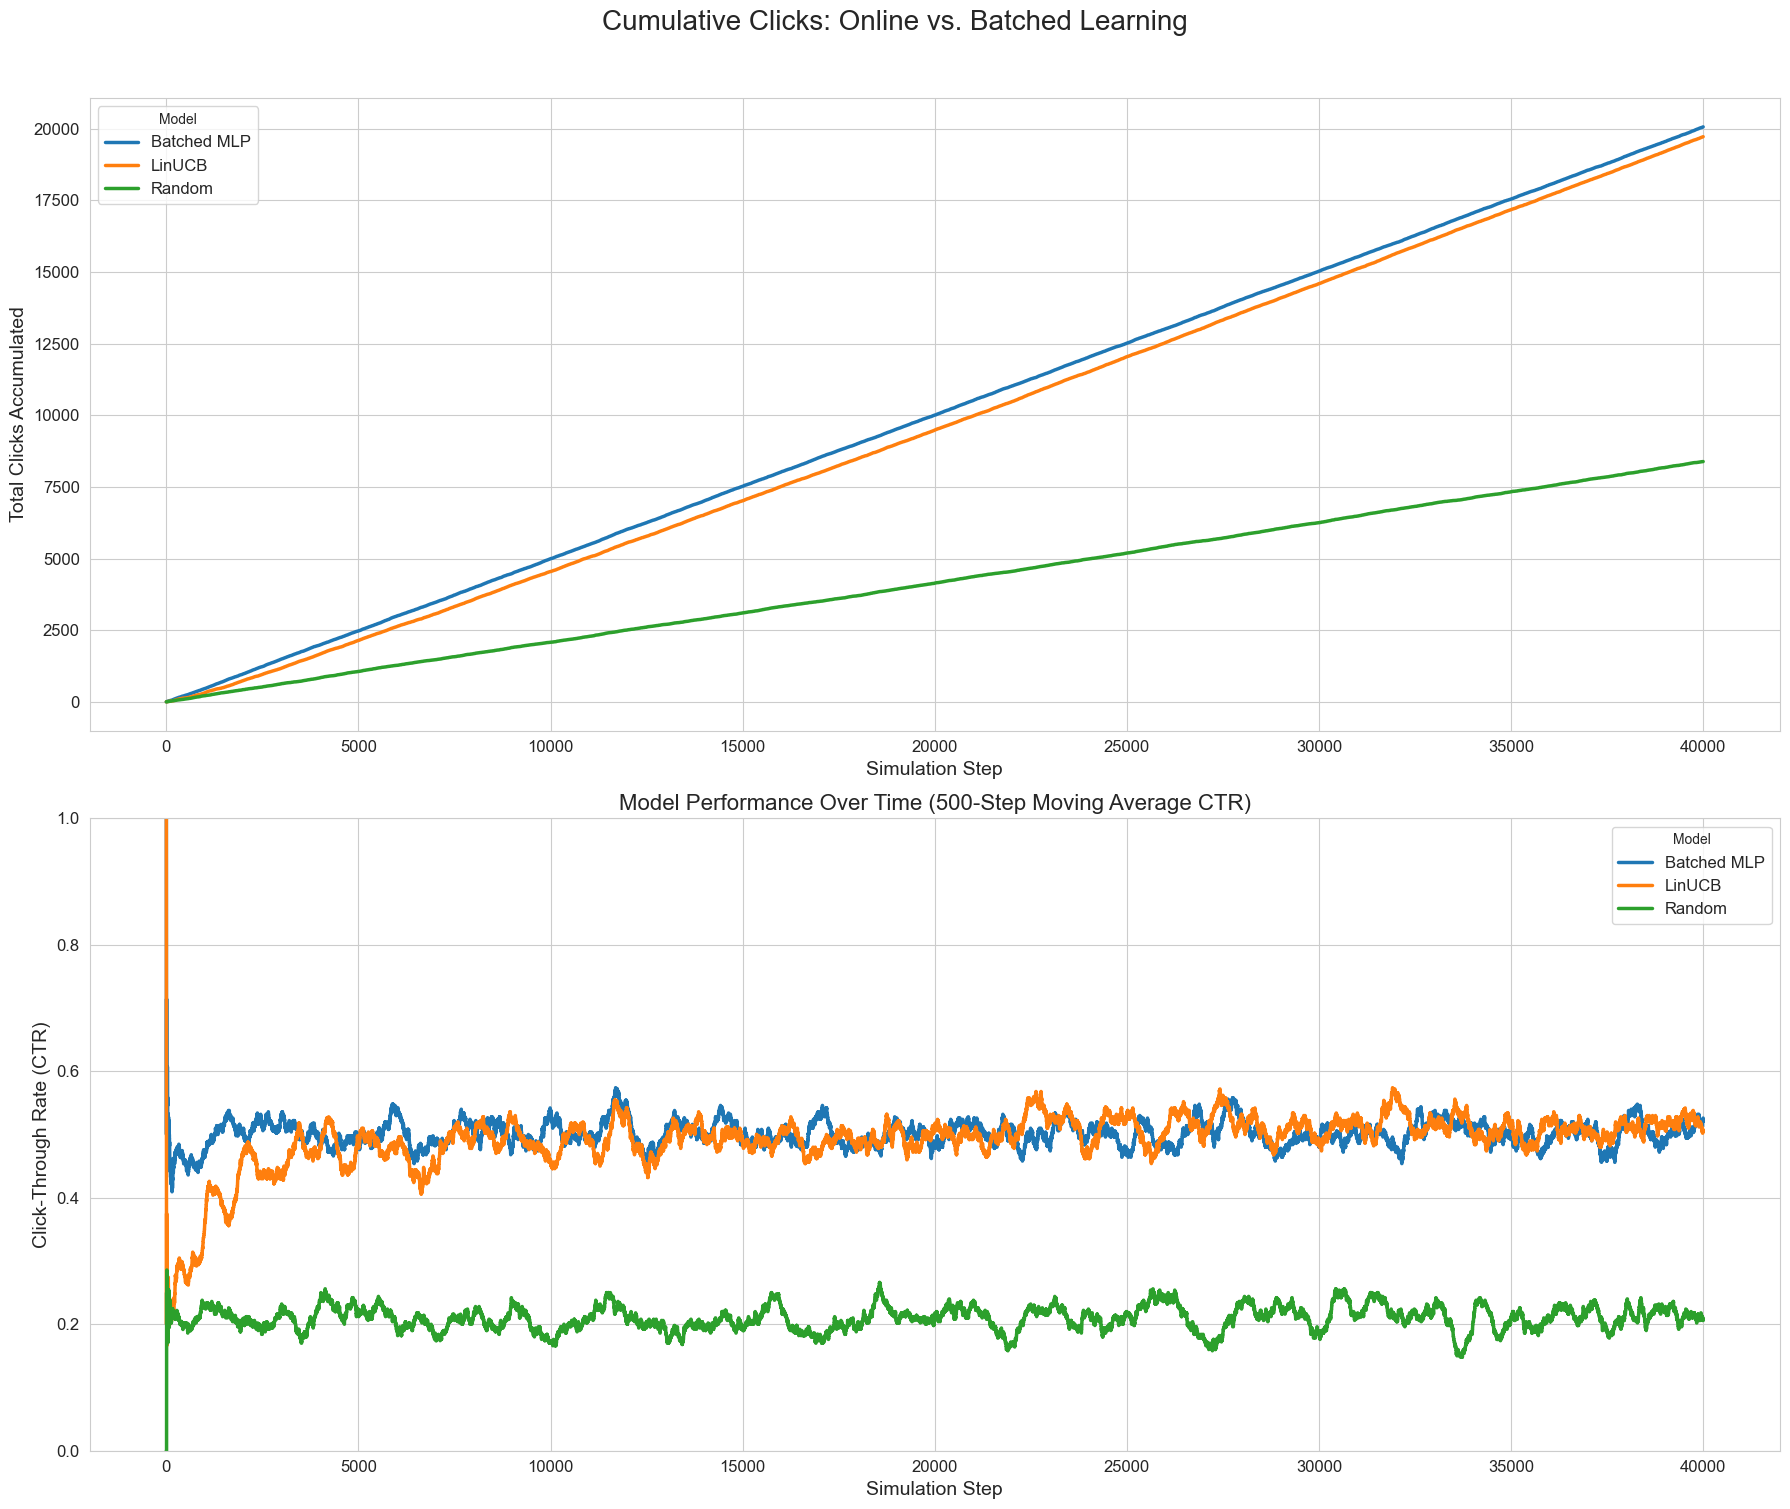

In [10]:
# --- Plotting the results ---
simulation_history['cumulative_reward'] = simulation_history.groupby('model')['reward'].cumsum()
simulation_history['moving_avg_ctr'] = simulation_history.groupby('model')['reward'].transform(lambda x: x.rolling(500, 1).mean())

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 16), dpi=100)
plt.suptitle('Cumulative Clicks: Online vs. Batched Learning', fontsize=20, y=0.94)

# Plot 1: Cumulative Reward
sns.lineplot(data=simulation_history, x='step', y='cumulative_reward', hue='model', ax=ax1, linewidth=2.5)
ax1.set_title('') # Title is now the main suptitle
ax1.set_xlabel('Simulation Step', fontsize=14)
ax1.set_ylabel('Total Clicks Accumulated', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(title='Model', fontsize=12)

# Plot 2: Moving Average CTR
sns.lineplot(data=simulation_history, x='step', y='moving_avg_ctr', hue='model', ax=ax2, linewidth=2.5)
ax2.set_title('Model Performance Over Time (500-Step Moving Average CTR)', fontsize=16)
ax2.set_xlabel('Simulation Step', fontsize=14)
ax2.set_ylabel('Click-Through Rate (CTR)', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(title='Model', fontsize=12)
ax2.set_ylim(0, 1.0) # Set y-axis to be from 0 to 1

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

#### **2.5 The True Test: Adaptation in a Non-Stationary World**

The previous simulation demonstrated a close race, a testament to the strength of our pre-trained MLP. However, its greatest weakness—its static nature—was never truly tested. Real-world systems are **non-stationary**: new products are introduced, user tastes evolve, and market trends shift. An intelligent system must adapt to these changes.

To simulate this, we will introduce a "market shock" midway through our experiment. We will add a new, highly desirable product category to our catalog and simultaneously alter the preferences of one of our user personas to favor this new category.

**Step 1: Modifying the Simulator**

We must first empower our `ZooplusSimulator` to introduce this change dynamically.

**Code Block 2.3: Adding a Market Shock to the Simulator**
```python
# We will add this method to the ZooplusSimulator class
def introduce_market_shock(self):
    """
    Simulates a change in the market by adding a new product category
    and updating a user persona's preferences.
    """
    print("Introducing a new product category: 'Premium Vet Diets'")
    # 1. Define new category and update an existing product to belong to it.
    # A more complex sim would add new products, but re-assigning is sufficient here.
    new_category = 'Premium Vet Diets'
    product_to_change_id = self.rng.integers(0, self.n_products)
    self.products.loc[product_to_change_id, 'category'] = new_category
    
    # 2. Update a persona to have a high affinity for the new category.
    # The 'budget_shopper' suddenly has a pet with a health issue.
    print("Updating 'budget_shopper' persona preferences.")
    self.personas['budget_shopper'][new_category] = 0.75 # Very high CTR
    # We can optionally reduce their interest in other things
    self.personas['budget_shopper']['Dog Food'] = 0.10
    self.personas['budget_shopper']['Cat Food'] = 0.15
```

This simple method models a realistic event. A new product line appears, and a segment of users (`budget_shopper`s who now need vet food) develops a strong preference for it. The `Batched MLP` has never seen the 'Premium Vet Diets' category and has no knowledge of this new preference structure. The `LinUCBAgent`, however, can learn about it through exploration.

In [11]:
# Data simulation, See chapter 1
import numpy as np
import pandas as pd

class ZooplusSimulatorShock:
    """
    A simulated environment for the Zooplus recommendation problem.

    This class manages:
    1. A product catalog with features (category).
    2. A set of user personas with distinct preferences.
    3. A stochastic reward function to simulate user clicks (CTR).
    """
    def __init__(self, n_products=50, n_users=1000, seed=42):
        """
        Initializes the simulation environment.
        
        Args:
            n_products (int): The total number of products in the catalog.
            n_users (int): The total number of unique users in the simulation.
            seed (int): Random seed for reproducibility.
        """
        self.rng = np.random.default_rng(seed)
        self.n_products = n_products
        self.n_users = n_users
        
        # 1. Create the Product Catalog
        self.products = self._create_product_catalog()
        
        # 2. Create User Personas and assign each of the n_users to a persona
        self.personas = self._create_user_personas()
        self.user_to_persona_map = self._assign_users_to_personas()

    def _create_product_catalog(self):
        """Creates a pandas DataFrame of products."""
        product_ids = range(self.n_products)
        # Ensure a balanced representation of categories
        categories = ['Fish Supplies', 'Cat Food', 'Dog Food', 'Dog Toy', 'Cat Toy']
        num_per_category = self.n_products // len(categories)
        cat_list = []
        for cat in categories:
            cat_list.extend([cat] * num_per_category)
        # Fill the remainder, if any
        cat_list.extend(self.rng.choice(categories, self.n_products - len(cat_list)))
        
        product_data = {
            'product_id': product_ids,
            'category': self.rng.permutation(cat_list) # Shuffle categories
        }
        return pd.DataFrame(product_data).set_index('product_id')

    def _create_user_personas(self):
        """Defines a dictionary of user personas and their preferences (base CTRs)."""
        return {
            'new_puppy_parent': {'Dog Food': 0.40, 'Dog Toy': 0.50, 'Cat Food': 0.10, 'Cat Toy': 0.05, 'Fish Supplies': 0.02},
            'cat_connoisseur':  {'Dog Food': 0.05, 'Dog Toy': 0.02, 'Cat Food': 0.55, 'Cat Toy': 0.45, 'Fish Supplies': 0.05},
            'budget_shopper':   {'Dog Food': 0.25, 'Dog Toy': 0.15, 'Cat Food': 0.40, 'Cat Toy': 0.20, 'Fish Supplies': 0.20},
            'fish_hobbyist':    {'Dog Food': 0.02, 'Dog Toy': 0.02, 'Cat Food': 0.10, 'Cat Toy': 0.08, 'Fish Supplies': 0.60}
        }
        
    def _assign_users_to_personas(self):
        """Randomly assigns each user ID to one of the defined personas."""
        persona_names = list(self.personas.keys())
        return {user_id: self.rng.choice(persona_names) for user_id in range(self.n_users)}

    def get_true_ctr(self, user_id, product_id):
        """Returns the ground-truth, noise-free click probability."""
        if user_id not in self.user_to_persona_map or product_id not in self.products.index:
            return 0.0
            
        persona_name = self.user_to_persona_map[user_id]
        persona_prefs = self.personas[persona_name]
        
        product_category = self.products.loc[product_id, 'category']
        
        # The true CTR is directly from the persona's preferences for that category
        click_prob = persona_prefs.get(product_category, 0.01) # Default for unknown categories
        return click_prob

    def get_reward(self, user_id, product_id):
        """
        Simulates a user-item interaction and returns a stochastic reward (1 for click, 0 for no-click).
        """
        click_prob = self.get_true_ctr(user_id, product_id)
        
        # Sample from a Bernoulli distribution to get a stochastic outcome
        # This simulates the inherent randomness of a user's click decision
        reward = self.rng.binomial(1, click_prob)
        return reward

    def get_random_user(self):
        """Returns a random user_id from the population."""
        return self.rng.integers(0, self.n_users)
    
    def introduce_market_shock(self):
        """
        Simulates a change in the market by dramatically altering a persona's
        preferences for an EXISTING product category. This changes the reward
        dynamics without altering the feature dimension.
        """
        target_persona = 'budget_shopper'
        target_category = 'Fish Supplies'
        
        print(f"\n--- MARKET SHOCK! ---")
        print(f"Updating '{target_persona}' persona preferences for '{target_category}'.")
        
        # The 'budget_shopper' suddenly develops a passion for aquariums.
        # The key is that the reward for the (budget_shopper, Fish Supplies)
        # context changes dramatically.
        self.personas[target_persona][target_category] = 0.80 # New, very high CTR
        
        self.personas[target_persona]['Dog Food'] = 0.10
        self.personas[target_persona]['Cat Food'] = 0.15
        print("Environment has been updated.\n")      

In [12]:
sim_shock = ZooplusSimulatorShock(seed=42)

In [ ]:
def run_simulation(sim, models, feature_engineer, batch_model_path, num_steps=40_000, market_shock_step=None):
    """
    Runs an online simulation to compare different recommendation models.
    """
    history = []
    
    # Load the pre-trained batched model from Chapter 1
    batched_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products).to(device)
    batched_model.load_state_dict(torch.load(batch_model_path))
    batched_model.eval()

    # Add a simple random model for comparison
    models['Random'] = None # Placeholder for the random agent

    for i in range(num_steps):
        if (i + 1) % 5000 == 0:
            print(f"Simulating step {i+1}/{num_steps}...")

        if market_shock_step and i == market_shock_step:
            sim.introduce_market_shock()            
            
        # 1. A new user interaction begins
        user_id = sim.get_random_user()
        
        # --- Batched Model's Turn (Pure Exploitation) ---
        with torch.no_grad():
            preds = get_batch_model_predictions(batched_model, user_id, sim.n_products, device)
            batched_choice = np.argmax(preds)
        batched_reward = sim.get_reward(user_id, batched_choice)
        history.append({'step': i, 'model': 'Batched MLP', 'reward': batched_reward, 'choice': batched_choice})
        
        # --- LinUCB Agent's Turn (Explore + Exploit) ---
        features = feature_engineer.create_features(user_id, sim)
        linucb_choice = models['LinUCB'].predict(features)
        linucb_reward = sim.get_reward(user_id, linucb_choice)
        history.append({'step': i, 'model': 'LinUCB', 'reward': linucb_reward, 'choice': linucb_choice})
        
        # ** THE CRUCIAL STEP: ONLINE LEARNING **
        # The LinUCB agent updates itself with the new information. The batched model does not.
        chosen_feature_vector = features[linucb_choice]
        models['LinUCB'].update(linucb_choice, linucb_reward, chosen_feature_vector)

        # --- Random Model's Turn (Pure Exploration) ---
        random_choice = sim.rng.integers(0, sim.n_products)
        random_reward = sim.get_reward(user_id, random_choice)
        history.append({'step': i, 'model': 'Random', 'reward': random_reward, 'choice': random_choice})
        
    return pd.DataFrame(history)

# --- Run the experiment ---
models_to_test = {'LinUCB': linucb_agent}
# Re-use the model trained in Chapter 1. Let's assume the file is "batch_recommender_model.pth"
simulation_history = run_simulation(sim_shock, models_to_test, feature_engineer, batch_model_path="batch_recommender_model_ch2_debug.pth", num_steps=40_000, market_shock_step=30_000)

print("\nSimulation Finished.")
print("--- Overall Performance ---")
print(simulation_history.groupby('model')['reward'].mean().reset_index().rename(columns={'reward': 'Overall CTR'}).sort_values('Overall CTR', ascending=False))

Simulating step 5000/40000...
Simulating step 10000/40000...
Simulating step 15000/40000...
Simulating step 20000/40000...
Simulating step 25000/40000...
Simulating step 30000/40000...

--- MARKET SHOCK! ---
Updating 'budget_shopper' persona preferences for 'Fish Supplies'.
Environment has been updated.

Simulating step 35000/40000...
Simulating step 40000/40000...

Simulation Finished.
--- Overall Performance ---
         model  Overall CTR
1       LinUCB     0.533375
0  Batched MLP     0.487750
2       Random     0.209850


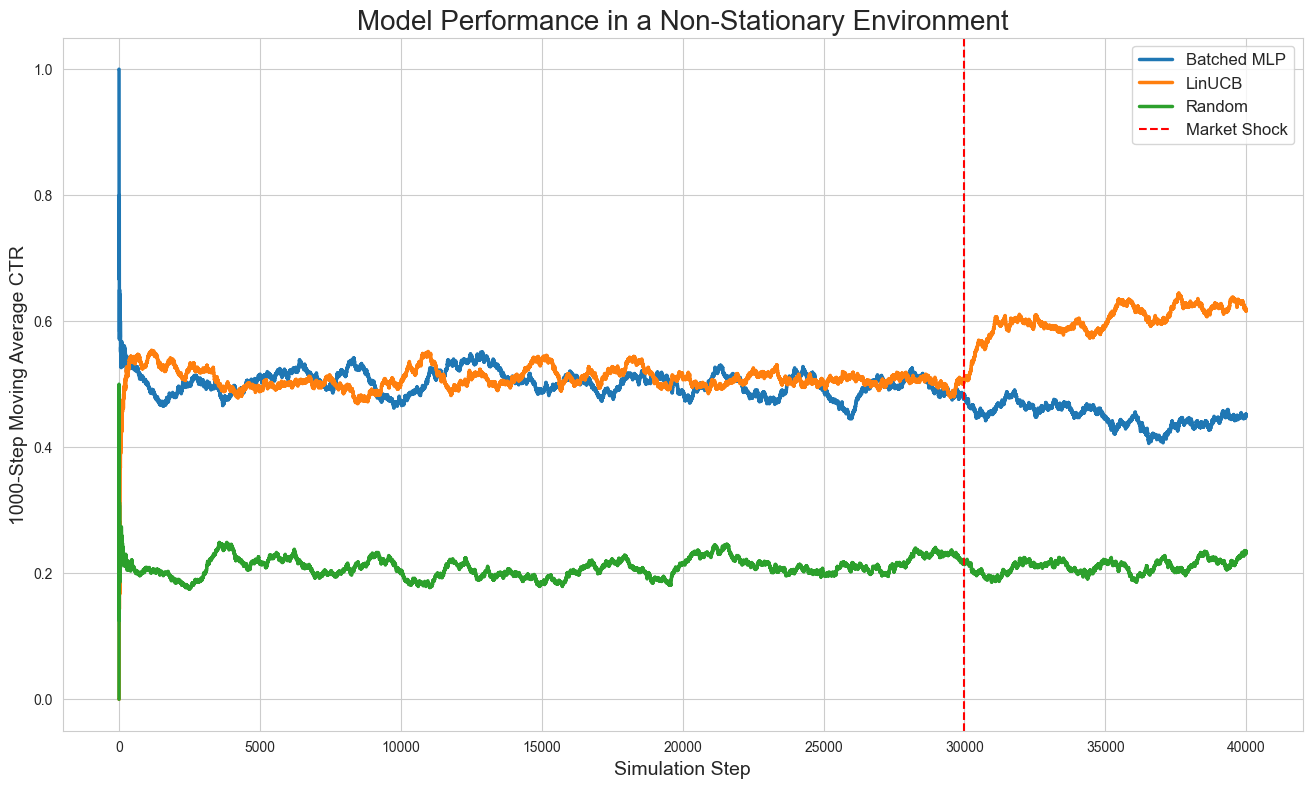

In [17]:
simulation_history['moving_avg_ctr'] = simulation_history.groupby('model')['reward']\
    .transform(lambda x: x.rolling(1000, 1).mean())

sns.set_style("whitegrid")
plt.figure(figsize=(16, 9))

sns.lineplot(data=simulation_history, x='step', y='moving_avg_ctr', hue='model', linewidth=2.5)

# Add a vertical line to indicate the market shock
plt.axvline(x=30000, color='r', linestyle='--', label='Market Shock')

plt.title('Model Performance in a Non-Stationary Environment', fontsize=20)
plt.xlabel('Simulation Step', fontsize=14)
plt.ylabel('1000-Step Moving Average CTR', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()